In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
from torchvision.models.inception import InceptionOutputs
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
class DeepDream(nn.Module):
    def __init__(self, model, layer_idx):
        super(DeepDream, self).__init__()
        self.features = self.get_required_layers(model, layer_idx)

    def forward(self, x):
        return self.features(x)

    def get_required_layers(self, model, layer_idx):
        if isinstance(model, nn.Sequential):
            return nn.Sequential(*list(model.children())[:layer_idx+1])
        elif isinstance(model, nn.Module):
            return model  # You might need to adjust this depending on the structure of your model
        else:
            raise ValueError("Unsupported model type")

In [3]:
def deep_dream(image_tensor, model, layer_idx, iterations, lr, octave_scale, output_path):
    # Convert image tensor to nn.Parameter
    img = nn.Parameter(image_tensor.to(device))

    # Define the deep dream model
    dream_model = DeepDream(model, layer_idx).to(device)
    
    # Define the optimizer
    optimizer = optim.Adam([img], lr=lr)
    
    # DeepDream iterations
    for i in range(iterations):
        optimizer.zero_grad()
        features = dream_model(img)
        loss = features.norm()
        loss.backward()
        optimizer.step()
    
        # Apply the octave scaling
        img.data = img.data + octave_scale * img.grad.data
    
        # Zero the gradient
        img.grad.data.zero_()
    
        # Clip the image values to be in the valid range
        img.data = torch.clamp(img.data, 0, 1)
    
    # Save the final deep dream image
    result = transforms.ToPILImage()(img.squeeze(0).cpu())
    result.save(output_path)

In [4]:
# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Specify the layer index for deep dream (you can experiment with different layers)
layer_index = 10

iterations = 20
learning_rate = 0.01
octave_scale = 1.4

In [5]:
train_transform = transforms.Compose([
    transforms.Resize((299, 299)),  # Resize images to the same dimensions as expected by InceptionV3
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize((299, 299)),  # Resize images to the same dimensions as expected by InceptionV3
    transforms.ToTensor()
])

In [6]:
model = models.inception_v3(pretrained=True).eval().to(device)

/home/user/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/user/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
train_dataset_pretrained = datasets.ImageFolder(root='./data_deepdream_pretrained/train', transform=train_transform)
test_dataset_pretrained = datasets.ImageFolder(root='./data_deepdream_pretrained/test', transform=test_transform)

In [8]:
train_dataloader = DataLoader(train_dataset_pretrained, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_dataset_pretrained, batch_size=8, shuffle=True)

In [9]:
def train_loop(dataloader, model, loss_fn, optimizer, device):
    model.train()
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        preds = model(X)
        if isinstance(preds, InceptionOutputs):
            logits = preds.logits
        else:
            logits = preds
            
        loss = loss_fn(logits, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

In [10]:
def test_loop(dataloader, model, loss_fn, device):
    model.eval()
    with torch.no_grad():
        total_loss = 0
        num_same = 0
        all_preds = []
        all_labels = []
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            if isinstance(outputs, InceptionOutputs):
                logits = outputs.logits
            else:
                logits = outputs
            loss = loss_fn(logits, y)
            total_loss += loss.item()

            _, preds = torch.max(logits, 1)
            num_same += (preds == y).sum().item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())
        
        print(f'Average loss: {total_loss / len(dataloader.dataset)}')
        print(f'Accuracy: {num_same / len(dataloader.dataset)}')

        return num_same / len(dataloader.dataset), all_labels, all_preds

In [17]:
class_weights = [0 for _ in range(1000)]
class_weights[0] = 0.62
class_weights[1] = 0.38
class_weights = torch.tensor(class_weights).to(device)

In [18]:
loss_fn = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters())
model.to(device)

num_epochs = 10
best_accuracy = 0.0
best_labels = None
best_preds = None

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    train_loop(train_dataloader, model, loss_fn, optimizer, device)
    accuracy, all_labels, all_preds = test_loop(test_dataloader, model, loss_fn, device)
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_labels = all_labels
        best_preds = all_preds

print(f'Best Accuracy: {best_accuracy}')

Epoch 1/10
Average loss: 0.08866688534617424
Accuracy: 0.5
Epoch 2/10
Average loss: 0.08341653457283973
Accuracy: 0.527
Epoch 3/10
Average loss: 0.08258479204773903
Accuracy: 0.541
Epoch 4/10
Average loss: 0.0790632404088974
Accuracy: 0.67
Epoch 5/10
Average loss: 0.08308817431330681
Accuracy: 0.662
Epoch 6/10
Average loss: 0.08645311494171619
Accuracy: 0.572
Epoch 7/10
Average loss: 0.07668103358149528
Accuracy: 0.657
Epoch 8/10
Average loss: 0.06874202544987201
Accuracy: 0.69
Epoch 9/10
Average loss: 0.06047038941830397
Accuracy: 0.736
Epoch 10/10
Average loss: 0.2181974651515484
Accuracy: 0.531
Best Accuracy: 0.736


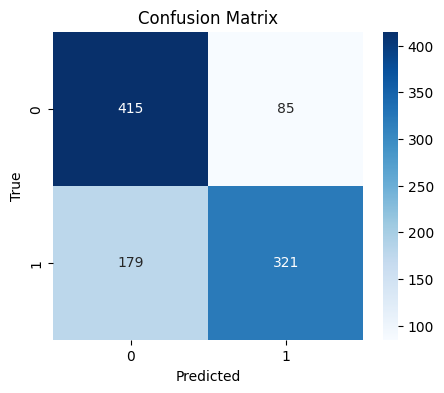

In [19]:
conf_matrix = confusion_matrix(best_labels, best_preds)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()